In [ ]:
!conda install -y -c conda-forge pyarrow python-snappy

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import time
from matplotlib import gridspec

In [9]:
plt.style.use("acm_ieee_latex_pubstyle.txt")

%matplotlib inline

# Initialize style
plt.style.use("acm_ieee_latex_pubstyle.txt")

plt.rcParams["axes.labelweight"] = "bold"

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 16.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    """Width driven sizing for seaborn multi-grid layouts
    
    Derive height & aspect kwargs for facetgrid, pairgrid & friends with a target sizing
    in terms of width and height.  Convenient for creating figures that has
    to be fit into a certain width, while maintaining the correct aspect ratios of the fonts.
    Call this function to derive the height & aspect
    
    Currently, ACM & IEEE latex, single column figure defaults to a width of 8inch
    and the double column figure defaults to a width of 8 inch for the correct text scaling
    
    Usage:
    - sns.FacetGrid( ... , **width_height())

    :param width: target width in inches (4 inch for a single column figure is default)
    :param height: target heigth in inches (width * 3/4 - golden ratio is the default)
    :param columns: target # of columns for facetgrid
    :param rows: target # of rows for facetgrid
    """
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

## Dataset Selection and Test Read

In [10]:
#power_ts_job_aware_10s
POWER_JOB_PATH = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/power_ts_job_aware_10s_2"

power_job_files = sorted(glob.glob(POWER_JOB_PATH + "/2*.csv"))


In [11]:
ti = time.time()

power_job_df = pd.read_csv(power_job_files[1]).sort_index()

tf = time.time()

print("Single File Read Time: ", tf-ti)

Single File Read Time:  0.5163297653198242


In [12]:
power_job_df = power_job_df.sort_values(by = ['allocation_id', 'timestamp'], ascending = [True, True])

power_job_df.head()

,timestamp,allocation_id,count_hostname,count_node_name,job_sch_node_num,count_inp,size_inp,sum_inp,count_top,size_top,...,mean_top,std_top,max_top,min_top,q25_inp,q50_inp,q75_inp,q25_top,q50_top,q75_top
0,2019-12-30 00:00:00+00:00,786910,214,214,214.0,214,214,215770.78,214,214,...,849.06750,30.300841,941.6667,592.11110,993.80554,1007.8889,1025.0833,832.88890,849.33330,865.63890
39,2019-12-30 00:00:10+00:00,786910,214,214,214.0,214,214,215773.36,214,214,...,848.73570,30.839450,927.2500,592.33330,993.36110,1007.2778,1024.9722,832.47220,848.33340,863.52780
78,2019-12-30 00:00:20+00:00,786910,214,214,214.0,214,214,215795.95,214,214,...,850.02484,31.602432,943.1250,594.00000,993.78125,1008.4375,1025.2188,832.90625,849.06250,869.10420
117,2019-12-30 00:00:30+00:00,786910,214,214,214.0,214,214,215756.78,214,214,...,848.69940,30.861802,938.6667,593.00000,993.33330,1008.0000,1024.8333,832.91660,848.44446,866.77783
156,2019-12-30 00:00:40+00:00,786910,214,214,214.0,214,214,215762.22,214,214,...,849.81464,30.663993,933.6667,595.55554,994.44446,1007.8334,1024.6389,836.25000,850.61110,865.88890


In [13]:
cols = power_job_df.columns

TIMESTAMP = cols[0]
ALLOC = cols[1]
NODECOUNT = cols[5]
NODESIZE = cols[6]
POWER = cols[7]

print(TIMESTAMP, ALLOC, NODECOUNT, NODESIZE, POWER)

timestamp allocation_id count_inp size_inp sum_inp


# Section 1: Calculate Job Rising and Falling Edges of greater than 4MW over 10 second intervals (Unused in Paper).

In [46]:
# Node counts which determine Summit job category classifications
cats = 5
cat_nodes = np.array([45, 91, 921, 2764])
leadership_nodes = np.max(cat_nodes)

# Total summit nodes and threshold for rising/falling edge definition
summit_nodes = 4608
thresh = 4e6

# Rising/Falling edge duration (1 timestep @ 10 seconds each)
dt = 1

# dt * 10sec + wind * 2 * 10sec => plotting durations (5 mins)
wind = 15

# Store file, allocation, timestamp_idx, rise/fall amount (W)
file_and_rise_idx = []
file_and_fall_idx = []

# 5 min snapshot around each rising/fall edge
rising = []
falling = []

# Which files have no rows
bad_files = []

# How many runs are equal to or less than "dt" in length
short_leadership = 0

# Which files to read
file_offset = 0
num_files = len(power_job_files)

# Timers
t_read = 0.0
t_prep = 0.0

t_i = time.time()
for i in range(file_offset, file_offset + num_files):
    if (i % 10 == 0):
        print("Processing File ", i)
    
    # READ A SINGLE FILE!
    t_ini = time.time()
    #################################
    power_df = pd.read_csv(power_job_files[i])
    #################################
    t_inf = time.time()
    t_read += t_inf - t_ini
    
    
    # PRE-PROCESS FILE, drop non-leadership class runs
    t_ini = time.time()
    #################################
    if len(power_df[POWER]) == 0:
        print("Bad File ", i, power_files[i])
        bad_files.append(i)
    
    big_power_df = power_df[power_df[NODECOUNT] > leadership_nodes]
    big_power_df = big_power_df.sort_values(by = [ALLOC, TIMESTAMP], ascending = [True, True])
    big_allocations = big_power_df[ALLOC].unique()
    #################################
    t_inf = time.time()
    t_prep += t_inf - t_ini
        
    # Loop through each leadership allocation in file
    for alloc in big_allocations:        
        alloc_df = big_power_df[big_power_df[ALLOC] == alloc]
        
        # Strong tolerance: If NodeCount is not equal to NodeSize, throw it out
        bad_count = np.sum(alloc_df[NODECOUNT] != alloc_df[NODESIZE])
        if bad_count:
#            print("Leadership alloc %s has bad node count/size in job" % (alloc))
            continue
    
        rows = len(alloc_df[POWER])
  
        # If NumTimesteps in job equal to or less than dt, then skip
        if rows <= dt:
            short_leadership += 1
            continue
        
        # Calculate Autocorrelated dataset: data[dt:] - data[:-dt]
        begin = np.array(alloc_df[POWER][:rows-dt])
        end = np.array(alloc_df[POWER][dt:]) 
        diff_inp = end - begin
        
        # Performance? : Skip if no sufficiently large rising/falling edges 
        if np.max(diff_inp) < thresh and np.min(diff_inp) > -1 * thresh:
#            print("Max diff: ", np.max(diff_inp), " Skipping")
            continue
    
        # Calculate Index of Rising and Falling edges of sufficient amount
        thresh_diffs_pos = np.where(diff_inp > thresh)
        thresh_diffs_neg = np.where(diff_inp < -1 * thresh)
    
        #print("\nRisings:  ", thresh_diffs_pos[0].size)
        #print("Fallings: ", thresh_diffs_neg[0].size)
    
        continuing_pos = -1
        continuing_neg = -1
    
        # Search each rising edge index that was found. Grab 5min snapshot around edge. 
        # Skip if idx is side-by-side the previous idx
        if (thresh_diffs_pos[0].size != 0):
            for j in range(len(thresh_diffs_pos[0])):

                idx = int(thresh_diffs_pos[0][j])     
                if idx == continuing_pos + 1:
                    continuing_pos += 1
                    continue
                
                new_slice = diff_inp[idx-wind:idx+dt+wind+1]

                if (len(new_slice) == wind*2 + dt + 1):
                    rising.append(diff_inp[idx-wind:idx+dt+wind+1])
                    file_and_rise_idx.append([i, alloc, idx, diff_inp[idx]])
                    continuing_pos = idx

        # Search each falling edge index.
        if (thresh_diffs_neg[0].size != 0):    
            for j in range(len(thresh_diffs_neg[0])):

                idx = int(thresh_diffs_neg[0][j])
                if idx == continuing_neg + 1:
                    continuing_neg += 1
                    continue
                
                new_slice = diff_inp[idx-wind:idx+dt+wind+1]

                if (len(new_slice) == wind*2 + dt + 1):
                    falling.append(new_slice)
                    file_and_fall_idx.append([i, alloc, idx, diff_inp[idx]])
                    continuing_neg = idx

        
        
#    print("File: ", i, " Rising Idx: ", thresh_diffs_pos)
#    print("File: ", i, " Falling Idx: ", thresh_diffs_neg)
    
t_f = time.time()
    
print("\nComplete!") 
print("Total Time: ", t_f - t_i) 
print("Time per file: ", (t_f - t_i)/num_files)
print("Read per file: ", (t_read / num_files))
print("Prep per file: ", (t_prep / num_files))

#print("\n\n\nRising Idx: ", file_and_rise_idx)
#print("Rising: ", rising)

#print("Falling Idx: ", file_and_fall_idx)
#print("Falling: ", falling)

Processing File  0
Processing File  10
Processing File  20
Processing File  30
Processing File  40
Processing File  50
Processing File  60
Processing File  70
Processing File  80
Processing File  90
Processing File  100
Processing File  110
Processing File  120
Processing File  130
Processing File  140
Processing File  150
Processing File  160
Processing File  170
Processing File  180
Processing File  190
Processing File  200
Processing File  210
Processing File  220
Processing File  230
Processing File  240
Processing File  250
Processing File  260
Processing File  270
Processing File  280
Processing File  290
Processing File  300
Processing File  310
Processing File  320
Processing File  330
Processing File  340
Processing File  350
Processing File  360
Processing File  370
Processing File  380
Processing File  390

Complete!
Total Time:  533.5961344242096
Time per file:  1.3612146286331877
Read per file:  1.3534617168562753
Prep per file:  0.005250829823163091


## Postprocess Edge Arrays

In [50]:
file_and_rise_idx_np = np.array(file_and_rise_idx)
file_and_fall_idx_np = np.array(file_and_fall_idx)

print(file_and_rise_idx_np.shape)
print(file_and_fall_idx_np.shape)

rising_np = np.array(rising)
falling_np = np.array(falling)

print(rising_np.shape)
print(falling_np.shape)

(165, 4)
(81, 4)
(165, 32)
(81, 32)


#### Steepest Rising and Falling Swing

In [48]:
print(np.max(file_and_rise_idx_np[:,3]))
print(np.min(file_and_fall_idx_np[:,3]))

5789771.0
-5892987.2


#### Calculate power from difference (autocorrel) data so that it begins (@ t_0) with power = 0

In [49]:
rising_shift_np = np.zeros(rising_np.shape)
falling_shift_np = np.zeros(falling_np.shape)

for i in range(rising_np.shape[0]):
    for j in range(rising_np.shape[1]):
        
        l = range(0, j, dt)
        
        rising_shift_np[i,j] = np.sum(rising_np[i,l])

for i in range(falling_np.shape[0]):
    for j in range(falling_np.shape[1]):
        
        l = range(0, j, dt)
        
        falling_shift_np[i,j] = np.sum(falling_np[i,l])

## Plot Job Rising/Falling Edges

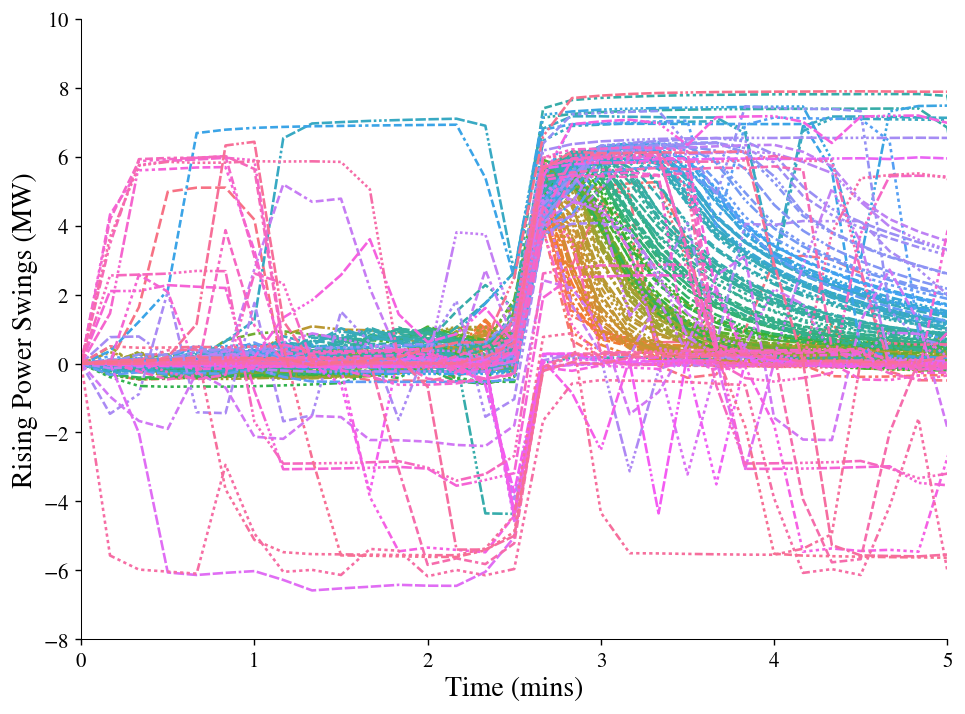

In [23]:
plt.close()

ax = sns.lineplot(data=np.transpose(rising_shift_np[:, :]) / 1e6)

ax.set_ylabel("Rising Power Swings (MW)")
ax.set_xlabel("Time (mins)")
ax.set_xlim([0, 30])

my_xticks = [0, 6, 12, 18, 24, 30]
my_xtick_labels= [0, 1, 2, 3, 4, 5] 

plt.xticks(my_xticks, my_xtick_labels)

plt.legend([],[], frameon=False)
plt.tight_layout()

#plt.savefig("Summit_2020_RisingEdges_%ds_%dMW.pdf" % (dt * 10, thresh / 1e6), format="pdf")

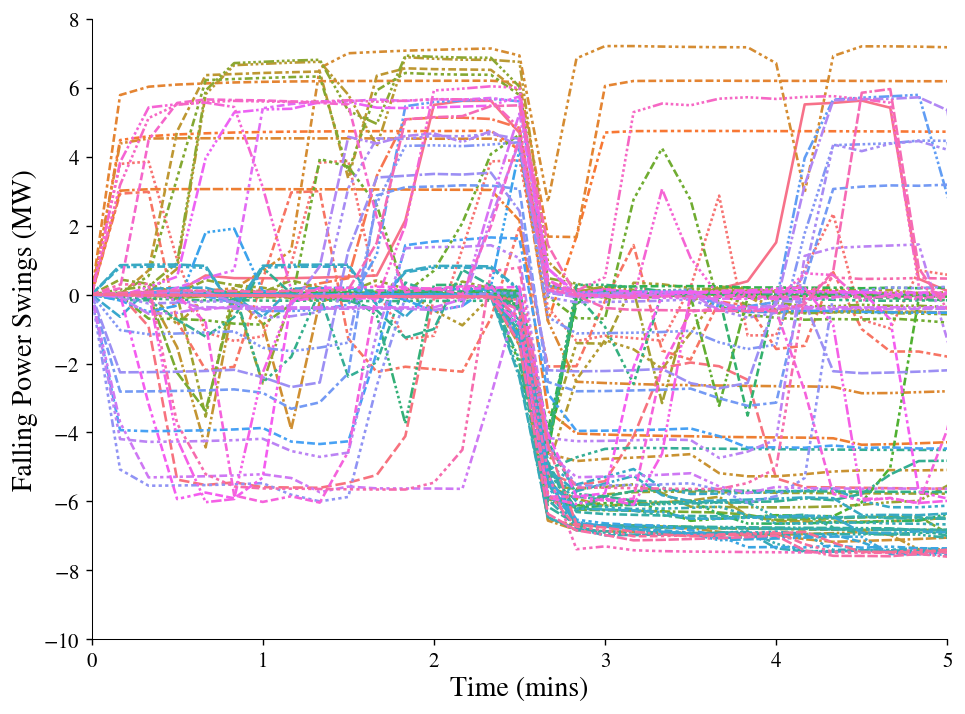

In [24]:
plt.close()

ax = sns.lineplot(data=np.transpose(falling_shift_np[:, :]) / 1e6)

ax.set_ylabel("Falling Power Swings (MW)")
ax.set_xlabel("Time (mins)")

ax.set_xlim([0, 30])

my_xticks = [0, 6, 12, 18, 24, 30]
my_xtick_labels= [0, 1, 2, 3, 4, 5] 

plt.xticks(my_xticks, my_xtick_labels)

plt.legend([],[], frameon=False)
plt.tight_layout()

#plt.savefig("Summit_2020_FallingEdges_%ds_%dMW.pdf" % (dt * 10, thresh / 1e6), format="pdf")

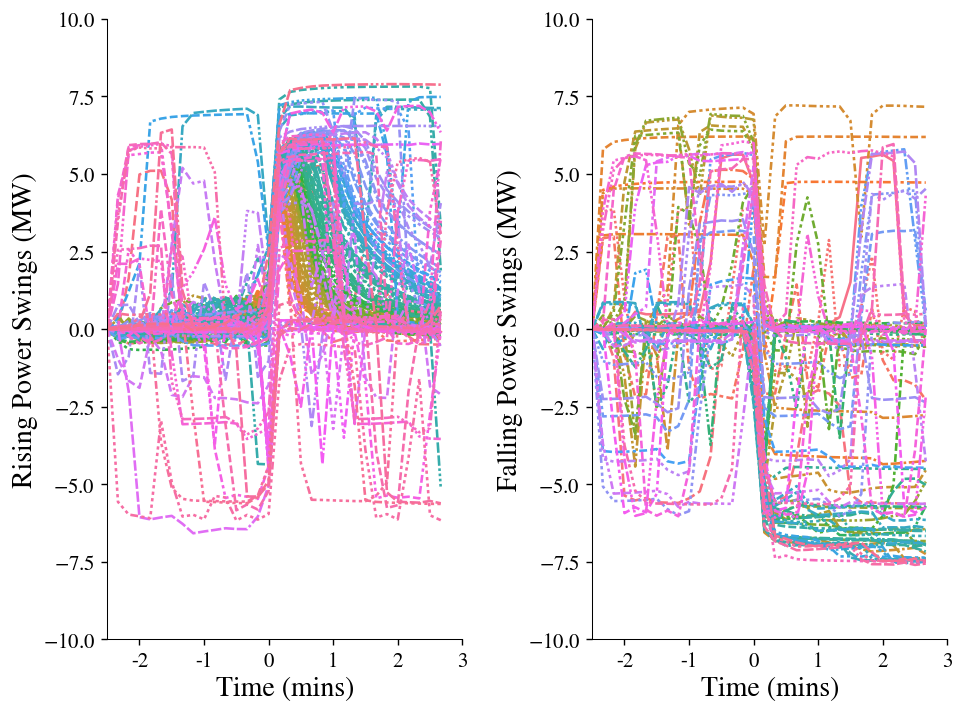

In [85]:
plt.close()

fig = plt.figure()

gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

ax1 = sns.lineplot(data=np.transpose(rising_shift_np[:, :]) / 1e6, ax=ax1)

ax1.set_ylabel("Rising Power Swings (MW)")
ax1.set_xlabel("Time (mins)")
ax1.set_xlim([0, 30])

my_xticks = [3, 9, 15, 21, 27, 33]
my_xtick_labels= [-2, -1, 0, 1, 2, 3] 

ax1.set_xticks(my_xticks)
ax1.set_xticklabels(my_xtick_labels)

ax1.set_ylim([-10, 10])

ax1.legend([],[], frameon=False)


ax2 = sns.lineplot(data=np.transpose(falling_shift_np[:, :]) / 1e6, ax=ax2)

ax2.set_ylabel("Falling Power Swings (MW)")
ax2.set_xlabel("Time (mins)")

ax2.set_xlim([0, 30])

my_xticks = [3, 9, 15, 21, 27, 33]
my_xtick_labels= [-2, -1, 0, 1, 2, 3] 

ax2.set_xticks(my_xticks)
ax2.set_xticklabels(my_xtick_labels)

ax2.legend([],[], frameon=False)
plt.tight_layout()

plt.savefig("Summit_2020_Rising_and_Falling_Edges_%ds_%dMW.pdf" % (dt * 10, thresh / 1e6), format="pdf")

# Section 2: Job Edge and Duration Distributions (Top Row of Figure 9)

In [7]:
# Node counts which determine Summit job category classifications
cats = 5
cat_nodes = np.array([45, 91, 921, 2764])
leadership_nodes = np.max(cat_nodes)

# Total summit nodes and threshold for rising/falling edge definition
summit_nodes = 4608
thresh = 4e6

# What determines a duration has completed? 80% return from peak/min power usage after a rising/falling edge
dur_percent = .80

# Rising/Falling edge duration (1 timestep @ 10 seconds each)
dt = 1

# How many runs in each category? How many runs are equal to or less than "dt" in length? How many jobs have no edges?
cat_count = np.zeros(cats)
short_runs = np.zeros(cats)
noedge_count = np.zeros(cats)

# Rising edges and durations
cat_r_edges = [[], [], [], [], []]
cat_r_durs = [[], [], [], [], []]

# Falling edges and durations
cat_f_edges = [[], [], [], [], []]
cat_f_durs = [[], [], [], [], []]

# Files with no rows
bad_files = []

# Which files to read
file_offset = 0
#num_files = 30
num_files = len(power_job_files)

# Internal Timers
t_read = 0.0
t_prep = 0.0

t_i = time.time()
for i in range(file_offset, file_offset + num_files):
    if (i % 10 == 0):
        print("Processing File ", i)
    
    # READ A SINGLE FILE!
    t_ini = time.time()
    #################################
    power_df = pd.read_csv(power_job_files[i])
    #################################
    t_inf = time.time()
    t_read += t_inf - t_ini
    
    # PRE-PROCESS FILE, sort by allocation_id then timestamp
    t_ini = time.time()
    #################################
    if len(power_df[POWER]) == 0:
        print("Bad File ", i, power_files[i])
        bad_files.append(i)
    
    power_df = power_df.sort_values(by = [ALLOC, TIMESTAMP], ascending = [True, True])
    allocations = power_df[ALLOC].unique()
    #################################
    t_inf = time.time()
    t_prep += t_inf - t_ini
        
        
    # Loop through each leadership allocation in file
    for alloc in allocations:        
        alloc_df = power_df[power_df[ALLOC] == alloc]
        
        # Strong tolerance: If NodeCount is not equal to NodeSize, throw it out
        bad_count = np.sum(alloc_df[NODECOUNT] != alloc_df[NODESIZE])
        if bad_count:
            continue
    
        # Nodes in job allocation
        first_row = alloc_df.iloc[0]
        nodes = first_row[NODECOUNT]
        
        cat = np.searchsorted(cat_nodes, nodes, side='left', sorter=None)
        cat_count[cat] += 1
    
        rows = len(alloc_df[POWER])

        # If NumTimesteps in job equal to or less than dt, then skip
        if rows <= dt:
            short_runs[cat] += 1
            continue
        
        # Threshold weighted by nodes in job
        thresh_w = thresh / (summit_nodes / nodes)
        
        # Calculate Autocorrelated dataset: data[dt:] - data[:-dt]
        begin = np.array(alloc_df[POWER][:rows-dt])
        end = np.array(alloc_df[POWER][dt:]) 
        diff_inp = (end - begin) 
        
        # Performance? : Skip if no sufficiently large rising/falling edges
        if np.max(diff_inp) < thresh_w and np.min(diff_inp) > -1 * thresh_w:
#            print("Max diff: ", np.max(diff_inp), " Skipping")
            noedge_count[cat] += 1
            
            cat_r_edges[cat].append(0)
            cat_f_edges[cat].append(0)
            continue
    
        # Calculate Index of Rising and Falling edges of sufficient amount
        thresh_diffs_pos = np.where(diff_inp > thresh_w)
        thresh_diffs_neg = np.where(diff_inp < -1 * thresh_w)
    
        #print("\nRisings:  ", thresh_diffs_pos[0].size)
        #print("Fallings: ", thresh_diffs_neg[0].size)
    
        continuing_pos = -1
        continuing_neg = -1
        
        rise_e = thresh_diffs_pos[0].size
        fall_e = thresh_diffs_neg[0].size
    
        # Search each rising edge index that was found. Count edge and determine its duration, append to running list.
        # Skip if idx is side-by-side the previous idx
        if (rise_e != 0):
            for j in range(thresh_diffs_pos[0].size):

                idx = int(thresh_diffs_pos[0][j])     
                if idx == continuing_pos + 1:
                    continuing_pos += 1
                    continue
                
                start_val = begin[idx]
                remaining = begin[idx+dt:] - (start_val * dur_percent)
 
                sign_change = np.where(np.diff(np.sign(remaining)))[0]
                
                rise_dur = dt
        
                if (len(sign_change) > 0):
                    rise_dur += sign_change[0]
                else:
                    rise_dur += len(remaining)

                continuing_pos = idx
                
                cat_r_durs[cat].append(rise_dur)
                
            cat_r_edges[cat].append(rise_e)
            
        # No rising edges in this job
        else:
            cat_r_edges[cat].append(0)
        
        # Search each falling edge index that was found.
        if (fall_e != 0):    
            for j in range(thresh_diffs_neg[0].size):

                idx = int(thresh_diffs_neg[0][j])
                if idx == continuing_neg + 1:
                    continuing_neg += 1
                    continue
                
                start_val = begin[idx]
                remaining = begin[idx+dt:] - (start_val * dur_percent)
 
                sign_change = np.where(np.diff(np.sign(remaining)))[0]
                
                fall_dur = dt
        
                if (len(sign_change) > 0):
                    fall_dur += sign_change[0]
                else:
                    fall_dur += len(remaining)

                continuing_pos = idx
                
                cat_f_durs[cat].append(fall_dur)
            
            cat_f_edges[cat].append(fall_e)
        
        # No falling edges in this job
        else:
            cat_f_edges[cat].append(0)  
        
#    print("File: ", i, " Rising Idx: ", thresh_diffs_pos)
#    print("File: ", i, " Falling Idx: ", thresh_diffs_neg)
    
t_f = time.time()
    
print("\nComplete!") 
print("Total Time: ", t_f - t_i) 
print("Time per file: ", (t_f - t_i)/num_files)
print("Compute per file: ", (((t_f - t_i) - t_read - t_prep)/ num_files))
print("Read per file: ", (t_read / num_files))
print("Prep per file: ", (t_prep / num_files))


#print("\n\n\nRising Idx: ", file_and_rise_idx)
#print("Rising: ", rising)

#print("Falling Idx: ", file_and_fall_idx)
#print("Falling: ", falling)

Processing File  0
Processing File  10
Processing File  20
Processing File  30
Processing File  40
Processing File  50
Processing File  60
Processing File  70
Processing File  80
Processing File  90
Processing File  100
Processing File  110
Processing File  120
Processing File  130
Processing File  140
Processing File  150
Processing File  160
Processing File  170
Processing File  180
Processing File  190
Processing File  200
Processing File  210
Processing File  220
Processing File  230
Processing File  240
Processing File  250
Processing File  260
Processing File  270
Processing File  280
Processing File  290
Processing File  300
Processing File  310
Processing File  320
Processing File  330
Processing File  340
Processing File  350
Processing File  360
Processing File  370
Processing File  380
Processing File  390

Complete!
Total Time:  1970.0216851234436
Time per file:  5.025565523274091
Compute per file:  3.504617310908376
Read per file:  1.2036033503863277
Prep per file:  0.3173

#### Postprocess Job Edge and Duration Distribution Data

In [9]:
cat_count

array([754278.,  40284.,  39921.,   5054.,    785.])

In [10]:
print("Rising Edges")
print(len(cat_r_edges[0]))
print(len(cat_r_edges[1]))
print(len(cat_r_edges[2]))
print(len(cat_r_edges[3]))
print(len(cat_r_edges[4]))

print("\nFalling Edges")
print(len(cat_f_edges[0]))
print(len(cat_f_edges[1]))
print(len(cat_f_edges[2]))
print(len(cat_f_edges[3]))
print(len(cat_f_edges[4]))

print("\n\nRising Durations")
print(len(cat_r_durs[0]))
print(len(cat_r_durs[1]))
print(len(cat_r_durs[2]))
print(len(cat_r_durs[3]))
print(len(cat_r_durs[4]))

print("\nFalling Durations")
print(len(cat_f_durs[0]))
print(len(cat_f_durs[1]))
print(len(cat_f_durs[2]))
print(len(cat_f_durs[3]))
print(len(cat_f_durs[4]))

Rising Edges
754065
40271
39909
5054
785

Falling Edges
754065
40271
39909
5054
785


Rising Durations
90972
76755
10727
204
289

Falling Durations
91006
72956
9982
211
116


#### Create a new Edge and Duration DataFrame

In [11]:
# Create Edge DataFrame
cat_edge_df = pd.DataFrame(columns=['Class', 'edges', 'type'])

idx = 0
offset = 0

cat_e_cat_col = np.array([])
cat_e_edges_col = np.array([])
cat_e_type_col = np.array([])

#cat_names = ['A-45','B-91','C-921','D-2764','E-4608']

ti = time.time()
for i in range(offset, cats):
    len_of_r_cat = len(cat_r_edges[i])
    len_of_f_cat = len(cat_f_edges[i])

    # CATS
    cat_r_for_df = np.array([int(5 - i)] * len_of_r_cat)
    cat_f_for_df = np.array([int(5 - i)] * len_of_f_cat)
        
    cat_e_cat_col = np.concatenate((cat_e_cat_col, cat_r_for_df))
    cat_e_cat_col = np.concatenate((cat_e_cat_col, cat_f_for_df))

    # EDGES
    cat_e_edges_col = np.concatenate((cat_e_edges_col, cat_r_edges[i]))
    cat_e_edges_col = np.concatenate((cat_e_edges_col, cat_f_edges[i]))
    
    # TYPES
    type_r_for_df = np.array(["Rising"] * len_of_r_cat)
    type_f_for_df = np.array(["Falling"] * len_of_f_cat)
    
    cat_e_type_col = np.concatenate((cat_e_type_col, type_r_for_df))
    cat_e_type_col = np.concatenate((cat_e_type_col, type_f_for_df))
    
    
    
cat_edge_df["Class"] = cat_e_cat_col
cat_edge_df["edges"] = cat_e_edges_col
cat_edge_df["type"] = cat_e_type_col
    
print("Number of Edge Counts: ", len(cat_edge_df))
tf = time.time()

print("Edge time: ", tf-ti)

print(cat_edge_df.head())


# Create Duration DataFrame
cat_dur_df = pd.DataFrame(columns=['cat', 'durs', 'type'])

cat_d_cat_col = np.array([])
cat_d_durs_col = np.array([])
cat_d_type_col = np.array([])

ti = time.time()
for i in range(offset, cats):
    len_of_r_cat = len(cat_r_durs[i])
    len_of_f_cat = len(cat_f_durs[i])


    # CATS
    cat_r_for_df = np.array([int(5 - i)] * len_of_r_cat)
    cat_f_for_df = np.array([int(5 - i)] * len_of_f_cat)
    
    cat_d_cat_col = np.concatenate((cat_d_cat_col, cat_r_for_df))
    cat_d_cat_col = np.concatenate((cat_d_cat_col, cat_f_for_df))

    # DURS
    cat_d_durs_col = np.concatenate((cat_d_durs_col, cat_r_durs[i]))
    cat_d_durs_col = np.concatenate((cat_d_durs_col, cat_f_durs[i]))
    
    # TYPES
    type_r_for_df = np.array(["Rising"] * len_of_r_cat)
    type_f_for_df = np.array(["Falling"] * len_of_f_cat)
    
    cat_d_type_col = np.concatenate((cat_d_type_col, type_r_for_df))
    cat_d_type_col = np.concatenate((cat_d_type_col, type_f_for_df))
    
cat_dur_df["Class"] = cat_d_cat_col
cat_dur_df["durs"] = cat_d_durs_col
cat_dur_df["type"] = cat_d_type_col

print("\nNumber of Edge Durations (= Total Number of Edges): ", len(cat_dur_df))
tf = time.time()

print("Dur time: ", tf-ti)

cat_dur_df["durs_mins"] = cat_dur_df["durs"] / 6

print(cat_dur_df.head())

Number of Edge Counts:  1680168
Edge time:  1.5374512672424316
   Class  edges    type
0    5.0    0.0  Rising
1    5.0    0.0  Rising
2    5.0    0.0  Rising
3    5.0    0.0  Rising
4    5.0    0.0  Rising

Number of Edge Durations (= Total Number of Edges):  353218
Dur time:  0.27075648307800293
   cat   durs    type  Class   durs_mins
0  NaN   17.0  Rising    5.0    2.833333
1  NaN  678.0  Rising    5.0  113.000000
2  NaN  676.0  Rising    5.0  112.666667
3  NaN  693.0  Rising    5.0  115.500000
4  NaN  685.0  Rising    5.0  114.166667


In [37]:
cat_edge_df["Class"] = cat_edge_df["Class"].apply(int)
cat_dur_df["Class"] = cat_dur_df["Class"].apply(int)

cat_edge_df.head()


,Class,edges,type
0,5,0.0,Rising
1,5,0.0,Rising
2,5,0.0,Rising
3,5,0.0,Rising
4,5,0.0,Rising


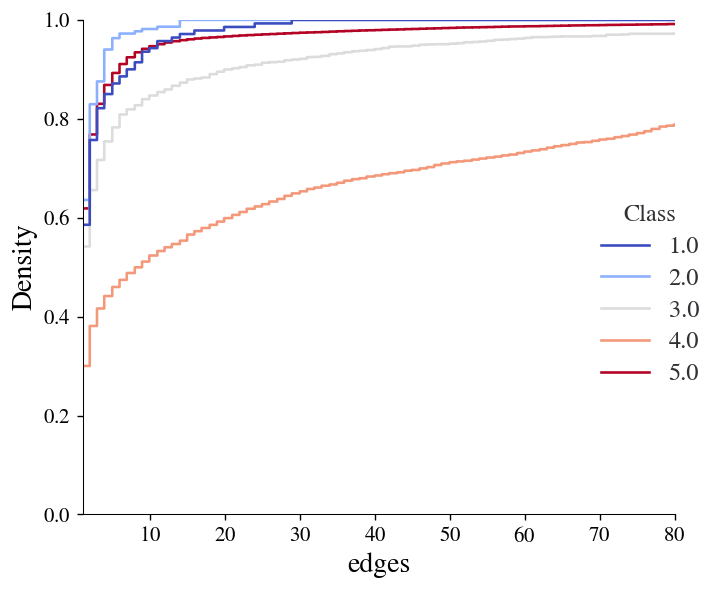

In [12]:
plt.close()

g = sns.displot(cat_edge_df[cat_edge_df["edges"] != 0], x='edges', hue='Class', palette="coolwarm", element="step", fill=False, cumulative=True, stat="density", common_norm=False)

g.ax.set_xlim([1, 80])
g.ax.set_ylim([0, 1])

plt.tight_layout()

#plt.savefig("Summit_2020_EdgeHist_10s_4MW.pdf", format="pdf")

plt.show()

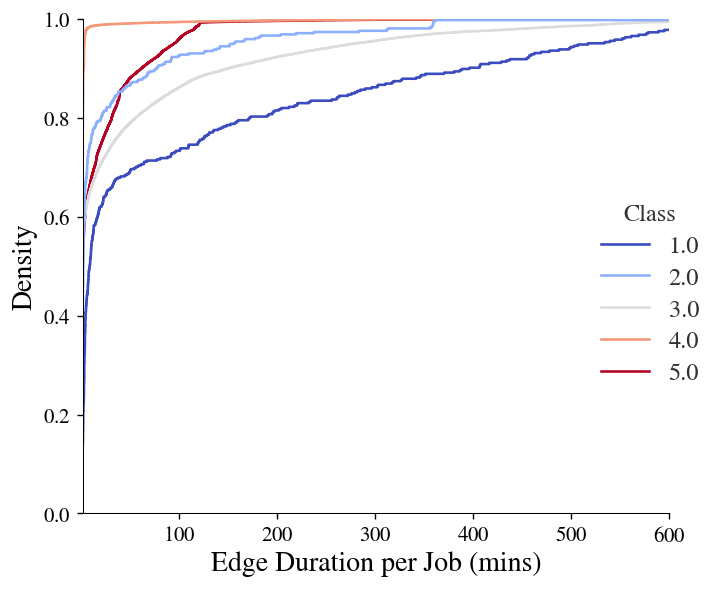

In [13]:
plt.close()

g = sns.displot(cat_dur_df, x='durs_mins', hue='Class', palette="coolwarm", element="step", fill=False, cumulative=True, stat="density", common_norm=False)

g.ax.set_xlabel("Edge Duration per Job (mins)")
g.ax.set_xlim([1, 600])
g.ax.set_ylim([0, 1])

plt.tight_layout()

#plt.savefig("Summit_2020_DurationHist_10s_4MW.pdf", format="pdf")

plt.show()

<Figure size 1000x750 with 0 Axes>

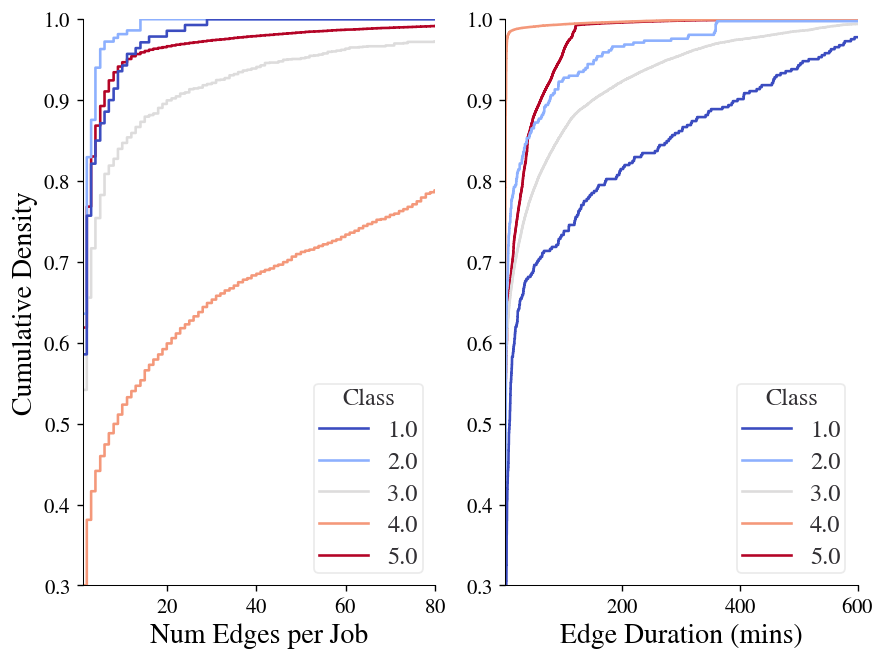

In [14]:
gridkw = dict(width_ratios=[1, 1])

plt.close()
plt.figure()

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw)


ax1 = sns.histplot(cat_edge_df[cat_edge_df["edges"] != 0], x='edges', hue='Class', palette="coolwarm", element="step", fill=False, cumulative=True, stat="density", common_norm=False, ax=ax1)

ax1.set_ylabel("Cumulative Density")
ax1.set_xlabel("Num Edges per Job")
ax1.set_xlim([1, 80])
ax1.set_ylim([0.3, 1])

ax2 = sns.histplot(cat_dur_df, x='durs_mins', hue='Class', palette="coolwarm", element="step", fill=False, cumulative=True, stat="density", common_norm=False, ax=ax2)

ax2.set_ylabel("")
ax2.set_xlabel("Edge Duration (mins)")
ax2.set_xlim([1, 600])
ax2.set_ylim([0.3, 1])

ax2.legend_._set_loc(4)

plt.tight_layout()

plt.savefig("Summit_2020_EdgeCount_and_Duration_10s_4MW.pdf", format="pdf")
plt.show()

## FFT Analysis

#### Example job power curves

In [15]:
print(power_job_df.columns)

power_leader = power_job_df[power_job_df["job_sch_node_num"] > 4000]
leaders = power_leader["allocation_id"].unique()

print(leaders)

Index(['timestamp', 'allocation_id', 'count_hostname', 'count_node_name',
       'job_sch_node_num', 'count_inp', 'size_inp', 'sum_inp', 'count_top',
       'size_top', 'sum_top', 'mean_inp', 'std_inp', 'max_inp', 'min_inp',
       'mean_top', 'std_top', 'max_top', 'min_top', 'q25_inp', 'q50_inp',
       'q75_inp', 'q25_top', 'q50_top', 'q75_top'],
      dtype='object')
[788050 788123 788125 788127 788130 788176]


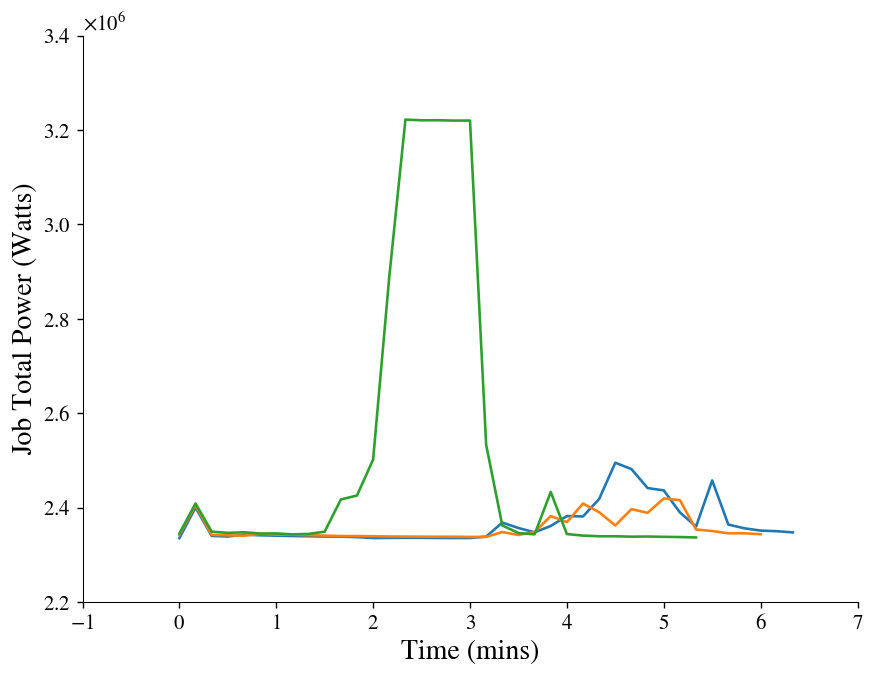

In [16]:
plt.close()

subpower0 = power_leader[power_leader["allocation_id"]==leaders[0]]
subpower1 = power_leader[power_leader["allocation_id"]==leaders[1]]
subpower2 = power_leader[power_leader["allocation_id"]==leaders[2]]

subpower0 = subpower0.reset_index()
subpower1 = subpower1.reset_index()
subpower2 = subpower2.reset_index()

sns.lineplot(data=subpower0, x=subpower0.index / 6, y='sum_inp')
sns.lineplot(data=subpower1, x=subpower1.index / 6, y='sum_inp')
sns.lineplot(data=subpower2, x=subpower2.index / 6, y='sum_inp')

plt.ylabel("Job Total Power (Watts)")
plt.xlabel("Time (mins)")

plt.show()

# Section 3: FFT Analysis of Job Swings (Bottom Row of Figure 9)

In [ ]:
# Node counts which determine Summit job category classifications
cats = 5
cat_nodes = np.array([45, 91, 921, 2764])

summit_nodes = 4608

# Rising/Falling edge duration (1 timestep @ 10 seconds each)
dt = 1

# How many frequencies to save per job? 
num_top_amps = 1

# Ignore changes below what power level threshold?
include_thresh = 4e5

drop_thresh = 0

# How many runs in each category? 
cat_count = np.zeros(cats)

# How many runs are equal to or less than "dt" in length? 
short_runs = np.zeros(cats)

# How many jobs with less than double num_top_amps frequencies in the FFT frequency domain
shortish_runs = np.zeros(cats)

# How many jobs with max change less than weighted threshold
not_included_runs = np.zeros(cats)

# Frequencies/Amplitudes/Job Durations for each category
cat_freqs = [[], [], [], [], []]
cat_amps = [[], [], [], [], []]
cat_job_durs = [[],[],[],[],[]]

# Maximum length of all jobs
max_duration = 0

# Files with no rows
bad_files = []

bad_count_total = np.zeros(cats)

# Files to read
file_offset = 0
num_files = len(power_job_files)

# Internal Timers
t_read = 0.0
t_prep = 0.0
t_fft = 0.0

t_i = time.time()
for i in range(file_offset, file_offset + num_files):
    if (i % 10 == 0):
        print("Processing File ", i)
       
    # READ THE FILES
    t_ini = time.time()
    #################################
    power_df = pd.read_csv(power_job_files[i])
    #################################
    t_inf = time.time()
    t_read += t_inf - t_ini
    
    
    # PREPROCESS THE FILE
    t_ini = time.time()
    #################################
    if len(power_df[POWER]) == 0:
        print("Bad File ", i, power_files[i])
        bad_files.append(i)
    
    # Sort by allocation then time
    power_df = power_df.sort_values(by = [ALLOC, TIMESTAMP], ascending = [True, True])
    allocations = power_df[ALLOC].unique()
    #################################
    t_inf = time.time()
    t_prep += t_inf - t_ini
        
    # Loop through each allocation
    for alloc in allocations:        
        alloc_df = power_df[power_df[ALLOC] == alloc]
        
        # Nodes in job allocation
        first_row = alloc_df.iloc[0]
        nodes = first_row[NODECOUNT]
        
        cat = np.searchsorted(cat_nodes, nodes, side='left', sorter=None)
        cat_count[cat] += 1
        
        # Strong tolerance: If NodeCount is not equal to NodeSize, throw it out
        bad_count = np.sum(alloc_df[NODECOUNT] != alloc_df[NODESIZE])
        
        if (bad_count > 0):
            bad_count_total[cat] += (bad_count > 0)
            continue
    
        rows = len(alloc_df[POWER])
           
        # If NumTimesteps in job equal to or less than dt, then skip
        if rows <= dt:
            short_runs[cat] += 1
            continue

        # Calculate the FFT on the DIFFERENCES between system power at successive time steps (autocorrelated data)
        powers = np.array(alloc_df[POWER])
        power_v = powers[1:] - powers[:-1]
             
        include_thresh_w = include_thresh * (nodes / summit_nodes)
        drop_thresh_w = drop_thresh * (nodes / summit_nodes)
        
        if np.max(np.abs(power_v)) < include_thresh_w:
            not_included_runs[cat] += 1
            continue
        
        if len(powers) > max_duration:
            max_duration = len(powers)

        # Drop changes in powers below a certain threshold amount
        power_v[np.abs(power_v) < drop_thresh_w] = 0
            
            
        # Calculate FFT using numpy
        # https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html
        Y    = np.fft.fft(power_v)
        freq = np.fft.fftfreq(len(power_v), 10)
        
        freq = np.abs(freq)
            
        # Continue if number of freqs is less than 2x the number of top amplitudes we want to obtain
        if len(Y) <= num_top_amps * 2:
            shortish_runs[cat] += 1
            continue
    
        # Combine real and imaginary components
        Y_sqrd = np.abs(Y) ** 2
        
        # Find top N amplitudes and their frequencies
        max_inds = np.argpartition(Y_sqrd, -1 * num_top_amps)[-1 * num_top_amps:]
        max_amps = Y_sqrd[max_inds]
    
        # Save data to lists under each category
        for k in range(num_top_amps):
            if (max_amps[k] == 0):
                continue
            
            cat_freqs[cat].append(freq[int(max_inds[k])])
            cat_amps[cat].append(max_amps[k])
            cat_job_durs[cat].append(len(powers))
    
    
#    print("File: ", i, " Rising Idx: ", thresh_diffs_pos)
#    print("File: ", i, " Falling Idx: ", thresh_diffs_neg)
    
t_f = time.time()
    
print("\nComplete!") 
print("Total Time: ", t_f - t_i) 
print("Time per file: ", (t_f - t_i)/num_files)
print("Compute per file: ", (((t_f - t_i) - t_read - t_prep)/ num_files))
print("Read per file: ", (t_read / num_files))
print("Prep per file: ", (t_prep / num_files))

#print("\n\n\nRising Idx: ", file_and_rise_idx)
#print("Rising: ", rising)

#print("Falling Idx: ", file_and_fall_idx)
#print("Falling: ", falling)

## Different Job Counts/Tallies for each Class

In [69]:
print("Runs less than 10s: ", short_runs)
print("Runs without sufficient samples for qualtiy FFT: ", shortish_runs)
print("Jobs per Class: ", cat_count)
print("Jobs without Edges: ", not_included_runs)
print("Jobs with Sensor Errors: ", bad_count_total)

Runs less than 10s:  [0. 0. 0. 0. 0.]
Runs without sufficient samples for qualtiy FFT:  [0. 0. 0. 0. 0.]
Jobs per Class:  [2666.  136.  352.   35.    8.]
Jobs without Edges:  [1078.   47.   53.   13.    4.]
Jobs with Sensor Errors:  [0. 0. 0. 0. 0.]


In [59]:
# Create new FFT DataFrame
cat_fft_df = pd.DataFrame(columns=['Class', 'freq', 'amp', 'dur'])

cat_col = np.array([])
cat_freq_col = np.array([])
cat_amp_col = np.array([])
cat_dur_col = np.array([])

cat_names = ['A-45','B-91','C-921','D-2764','E-4608']

ti = time.time()
for i in range(cats):
    len_of_cat = len(cat_freqs[i])


    # CATS
    cat_for_df = np.array([int(5 - i)] * len_of_cat)
    cat_col = np.concatenate((cat_col, cat_for_df))

    # Freq
    cat_freq_col = np.concatenate((cat_freq_col, cat_freqs[i]))
   
    # Amp
    cat_amp_col = np.concatenate((cat_amp_col, cat_amps[i]))        
    
    # Dur
    cat_dur_col = np.concatenate((cat_dur_col, cat_job_durs[i]))        
    
cat_fft_df["Class"] = cat_col
cat_fft_df["freq"] = cat_freq_col
cat_fft_df["amp"] = cat_amp_col
cat_fft_df["dur"] = cat_dur_col


In [62]:
cat_fft_df["abs_freq"] = np.abs(cat_fft_df["freq"])
cat_fft_df["dur_mins"] = np.abs(cat_fft_df["dur"] / 6)

print(np.sum(cat_fft_df["amp"] == 0))

cat_fft_drop_df = cat_fft_df[cat_fft_df["amp"] != 0]

print(np.sum(cat_fft_drop_df["amp"] == 0))

cat_fft_drop_df["amp_log"] = np.log10(np.sqrt(cat_fft_drop_df["amp"]))

cat_fft_df.head()

0
0


,Class,freq,amp,dur,abs_freq,dur_mins
0,5.0,0.000758,3.013778e+08,1981.0,0.000758,330.166667
1,5.0,0.033929,9.415544e+07,57.0,0.033929,9.500000
2,5.0,0.013830,6.703614e+09,95.0,0.013830,15.833333
3,5.0,0.045583,3.106843e+09,284.0,0.045583,47.333333
4,5.0,0.036493,1.661064e+08,212.0,0.036493,35.333333


In [63]:
cat_fft_drop_df["Class"] = (cat_fft_drop_df["Class"]).apply(int)

cat_fft_df.head()

,Class,freq,amp,dur,abs_freq,dur_mins
0,5.0,0.000758,3.013778e+08,1981.0,0.000758,330.166667
1,5.0,0.033929,9.415544e+07,57.0,0.033929,9.500000
2,5.0,0.013830,6.703614e+09,95.0,0.013830,15.833333
3,5.0,0.045583,3.106843e+09,284.0,0.045583,47.333333
4,5.0,0.036493,1.661064e+08,212.0,0.036493,35.333333


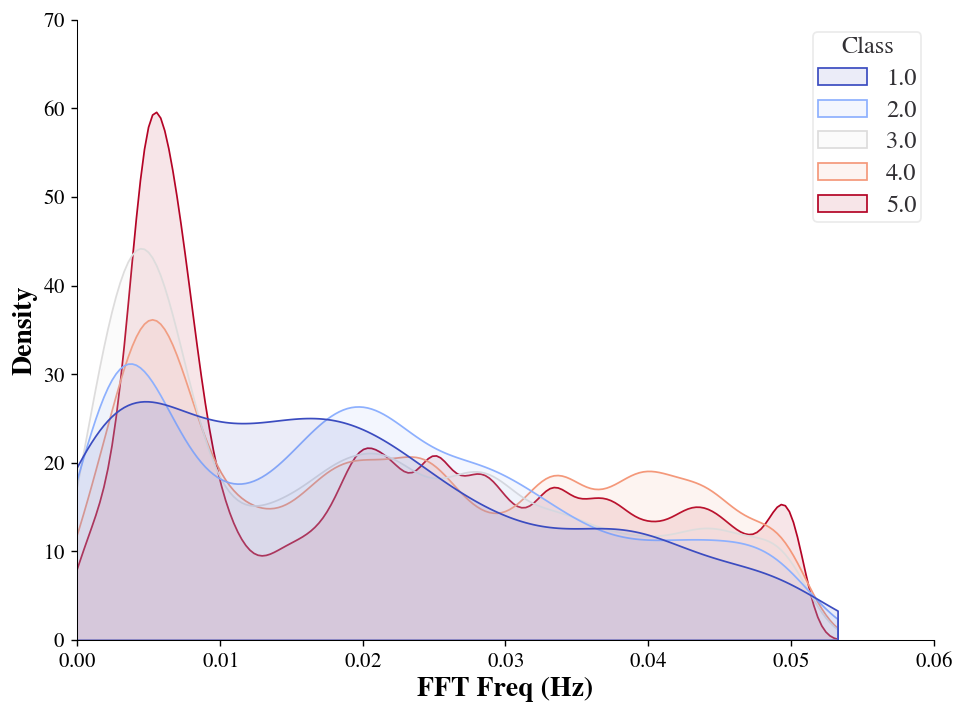

In [44]:
plt.close()
plt.figure()

ax = sns.kdeplot(data=cat_fft_df, x='abs_freq', hue='Class', common_grid=True, fill=True, common_norm=False, alpha=.1, palette="coolwarm")
#g = sns.rugplot(x=cat_fft_df['freq'], hue=cat_fft_df['Category'], palette="coolwarm")

ax.set_xlabel("FFT Freq (Hz)")
plt.xlim([0, .06])

plt.tight_layout()

plt.savefig("Summit_2020_DiffPower_FFT_IncludeThreshold_NoPowerThreshold_1Amps_NoZeros.pdf", format="pdf")
plt.show()

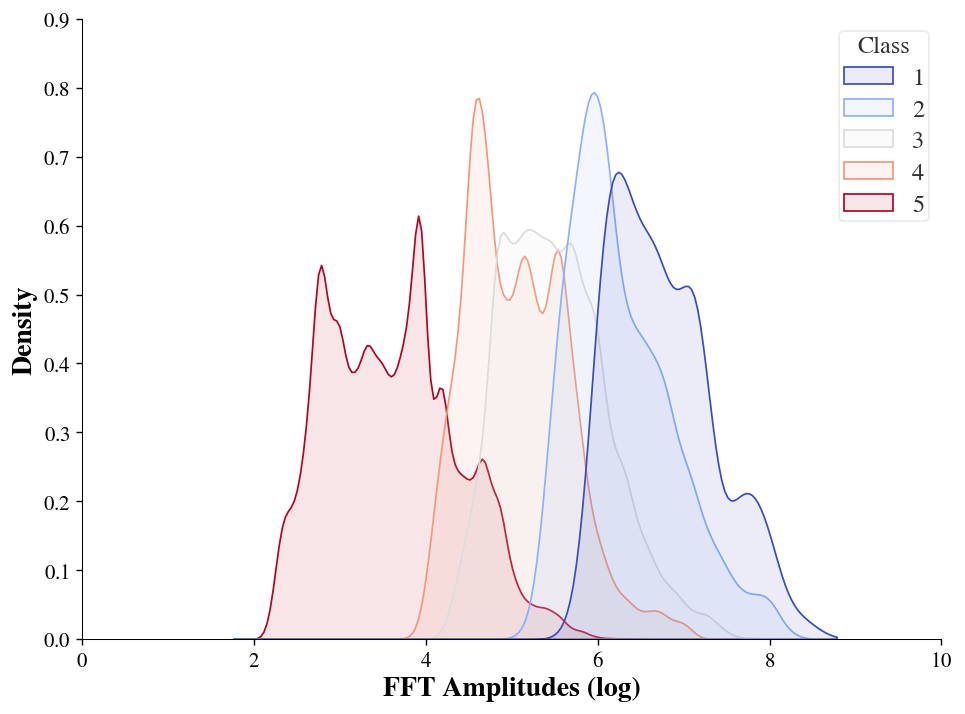

In [45]:
plt.close()
plt.figure()

ax = sns.kdeplot(data=cat_fft_drop_df, x='amp_log', hue='Class', common_grid=True, fill=True, common_norm=False, alpha=.1, palette="coolwarm")

ax.set_xlabel("FFT Amplitudes (log)")
plt.xlim([0, 10])

plt.tight_layout()

plt.savefig("Summit_2020_DiffPower_FFT_Amps_IncludeThreshold_NoPowerThreshold_1Amps_NoZeros.pdf", format="pdf")
plt.show()

<Figure size 1000x750 with 0 Axes>

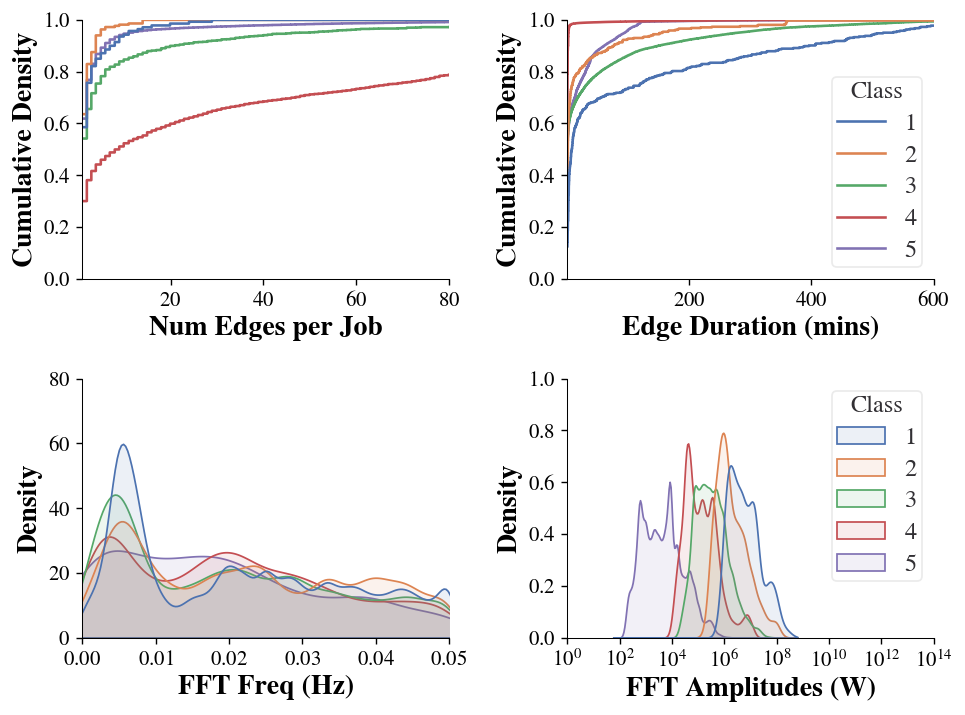

In [51]:
gridkw = dict(width_ratios=[1, 1], height_ratios=[1,1])

palette="deep"

plt.close()
plt.figure()

fig, axs = plt.subplots(2, 2, gridspec_kw=gridkw)

###### EDGE ANALYSIS

axs[0,0] = sns.histplot(cat_edge_df[cat_edge_df["edges"] != 0], x='edges', hue='Class', palette=palette, element="step", fill=False, cumulative=True, stat="density", common_norm=False, ax=axs[0,0])

axs[0,0].set_ylabel("Cumulative Density")
axs[0,0].set_xlabel("Num Edges per Job")
axs[0,0].set_xlim([1, 80])
axs[0,0].set_ylim([0, 1])

axs[0,0].legend_.remove()

axs[0,1] = sns.histplot(cat_dur_df, x='durs_mins', hue='Class', palette=palette, element="step", fill=False, cumulative=True, stat="density", common_norm=False, ax=axs[0,1])

axs[0,1].set_ylabel("Cumulative Density")
axs[0,1].set_xlabel("Edge Duration (mins)")
axs[0,1].set_xlim([1, 600])
axs[0,1].set_ylim([0, 1])

axs[0,1].legend_._set_loc(4)

###### FFT

axs[1,0] = sns.kdeplot(data=cat_fft_df, x='abs_freq', hue='Class', common_grid=True, fill=True, common_norm=False, alpha=.1, palette=palette, ax=axs[1,0])

axs[1,0].set_xlabel("FFT Freq (Hz)")
axs[1,0].set_xlim([0, .05])

axs[1,0].legend_.remove()

axs[1,1] = sns.kdeplot(data=cat_fft_drop_df, x='amp_log', hue='Class', common_grid=True, fill=True, common_norm=False, alpha=.1, palette=palette, ax=axs[1,1])

axs[1,1].set_xlabel("FFT Amplitudes (W)")
axs[1,1].set_xlim([0, 10])

axs[1,1].set_xticks([0,2,4,6,8,10,12,14])
axs[1,1].set_xticklabels(["$10^0$", "$10^2$", "$10^4$", "$10^6$", "$10^8$", "$10^{10}$", "$10^{12}$", "$10^{14}$"])

plt.tight_layout()

plt.savefig("Summit_2020_DiffPower_Edge_Analysis_and_FFT_OnlyEdges.pdf", format="pdf")
plt.show()

### Distribution of Job Durations by Class

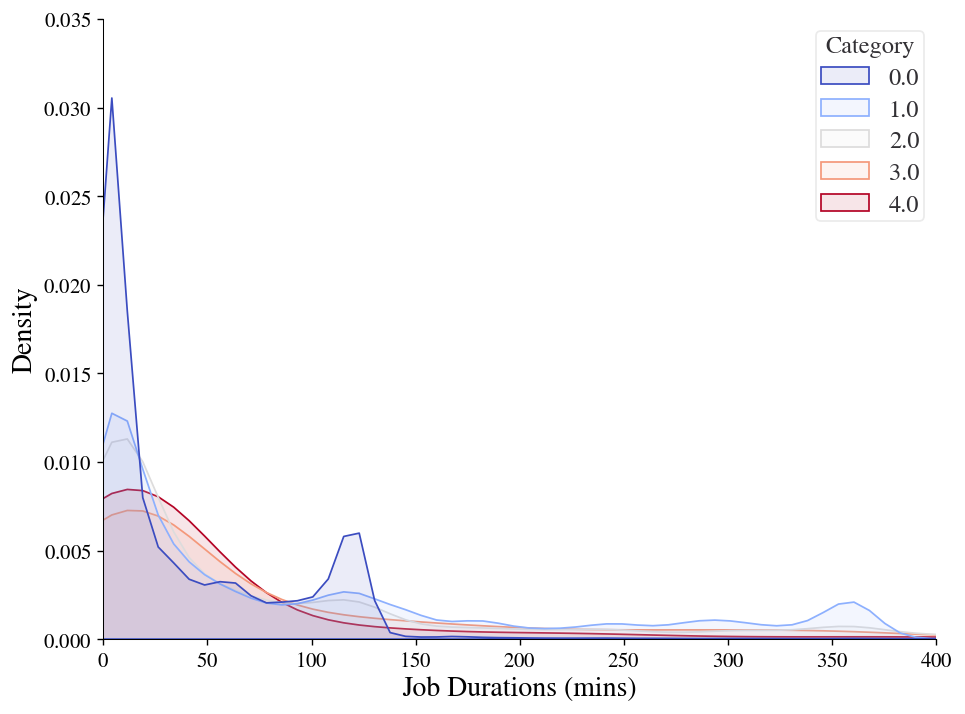

In [74]:
plt.close()
plt.figure()

ax = sns.kdeplot(data=cat_fft_df, x='dur_mins', hue='Category', common_grid=True, fill=True, common_norm=False, alpha=.1, palette="coolwarm")

ax.set_xlabel("Job Durations (mins)")
plt.xlim([0,400])

plt.tight_layout()

plt.show()

## Other Test FFT plots

In [8]:
file_idx = 270
leader_idx = 0

power_df = pd.read_csv(power_job_files[file_idx]).sort_index()

power_leader = power_df[power_df["job_sch_node_num"] > 4000]
leaders = power_leader["allocation_id"].unique()
print("Leadership job ids: ", leaders)

subpower = power_leader[power_leader["allocation_id"]==leaders[leader_idx]]
subpower = subpower.reset_index()

powers = np.array(subpower["sum_inp"])
diff_power = powers[1:] - powers[:-1]

Y    = np.fft.fft(diff_power)
freq = np.fft.fftfreq(len(diff_power), 10)

print("\nNum Freq: ", len(freq))

max_idx = np.argmax(np.abs(Y)**2)
max_freq = freq[max_idx]
print("Hi Freq: %d, %f4.4" % (max_idx, max_freq))
print("Max Amp Y: %f4.4" % (Y[max_idx]))

subpower2 = power_leader[power_leader["allocation_id"]==leaders[leader_idx + 1]]
subpower2 = subpower2.reset_index()

powers2 = np.array(subpower2["sum_inp"])
diff_power2 = powers2[1:] - powers2[:-1]

Y2    = np.fft.fft(diff_power2)
freq2 = np.fft.fftfreq(len(diff_power2), 10)

print("\nNum Freq: ", len(freq2))

max_idx2 = np.argmax(np.abs(Y2)**2)
max_freq2 = freq2[max_idx2]
print("Hi Freq: %d, %f4.4" % (max_idx2, max_freq2))
print("Max Amp Y: %f4.4" % (Y2[max_idx2]))

Leadership job ids:  [1412659 1412662]

Num Freq:  32
Hi Freq: 13, 0.0406254.4
Max Amp Y: 587516.8356724.4

Num Freq:  28
Hi Freq: 12, 0.0428574.4
Max Amp Y: 419712.1364644.4


<ipython-input-8-5ca98f2d1a19>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  print("Max Amp Y: %f4.4" % (Y[max_idx]))
<ipython-input-8-5ca98f2d1a19>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  print("Max Amp Y: %f4.4" % (Y2[max_idx2]))


In [9]:
num_top_amps = 3

Y_sqrd = np.abs(Y) ** 2

freq = np.abs(freq)
freq2 = np.abs(freq2)

test_max_inds = np.argpartition(Y_sqrd, -1 * num_top_amps)[-1 * num_top_amps:]
test_max_amps = Y_sqrd[test_max_inds]
test_max_freqs = freq[test_max_inds]

print(test_max_inds)
print(test_max_amps)
print(test_max_freqs)

Y_sqrd2 = np.abs(Y2) ** 2

test_max_inds2 = np.argpartition(Y_sqrd2, -1 * num_top_amps)[-1 * num_top_amps:]
test_max_amps2 = Y_sqrd2[test_max_inds2]
test_max_freqs2 = freq2[test_max_inds]

print(test_max_inds2)
print(test_max_amps2)
print(test_max_freqs2)

[21 13 19]
[2.41057808e+11 3.48268781e+11 3.48268781e+11]
[0.034375 0.040625 0.040625]
[24 12 16]
[1.69312191e+11 1.76896498e+11 1.76896498e+11]
[0.025      0.04642857 0.03214286]


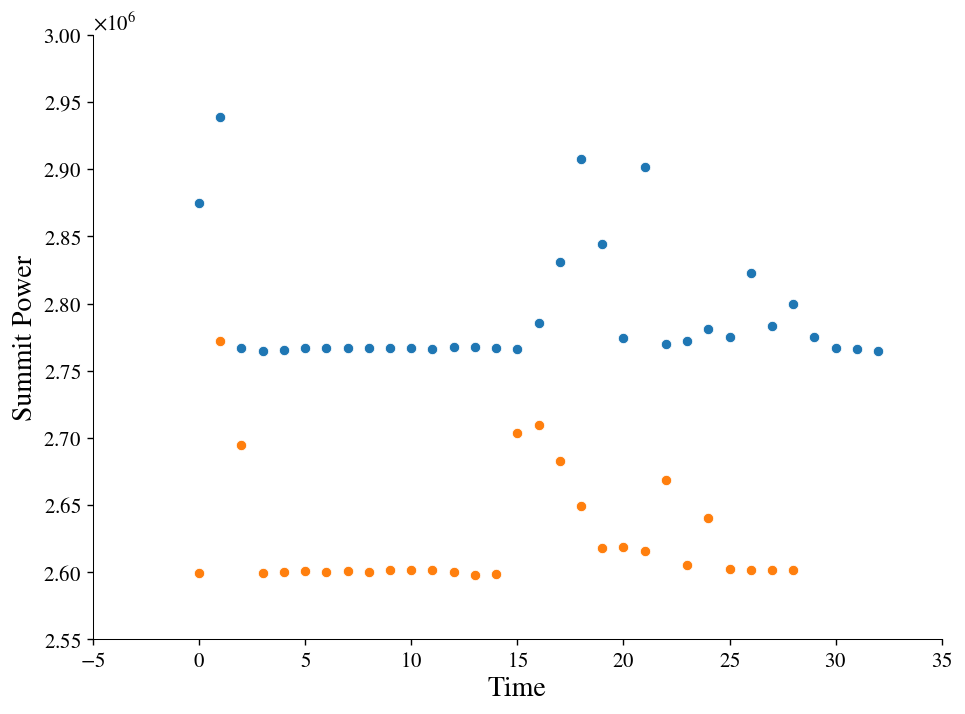

In [10]:
plt.close()
plt.figure()

ax = sns.scatterplot(x=subpower.index, y=powers)
ax = sns.scatterplot(x=subpower2.index, y=powers2)

ax.set_ylabel("Summit Power")
ax.set_xlabel("Time")

ax.autoscale_view()

plt.tight_layout()

plt.show()

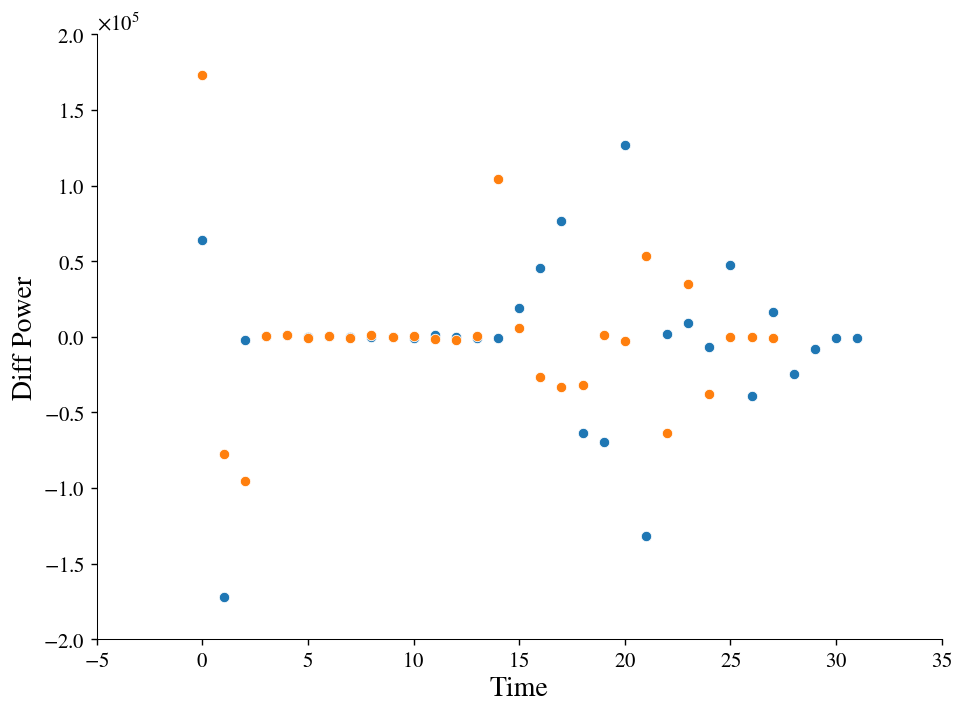

In [11]:
plt.close()
plt.figure()

ax = sns.scatterplot(x=subpower.index[:-1], y=diff_power)
ax = sns.scatterplot(x=subpower2.index[:-1], y=diff_power2)

ax.set_ylabel("Diff Power")
ax.set_xlabel("Time")

ax.autoscale_view()

plt.tight_layout()

plt.show()

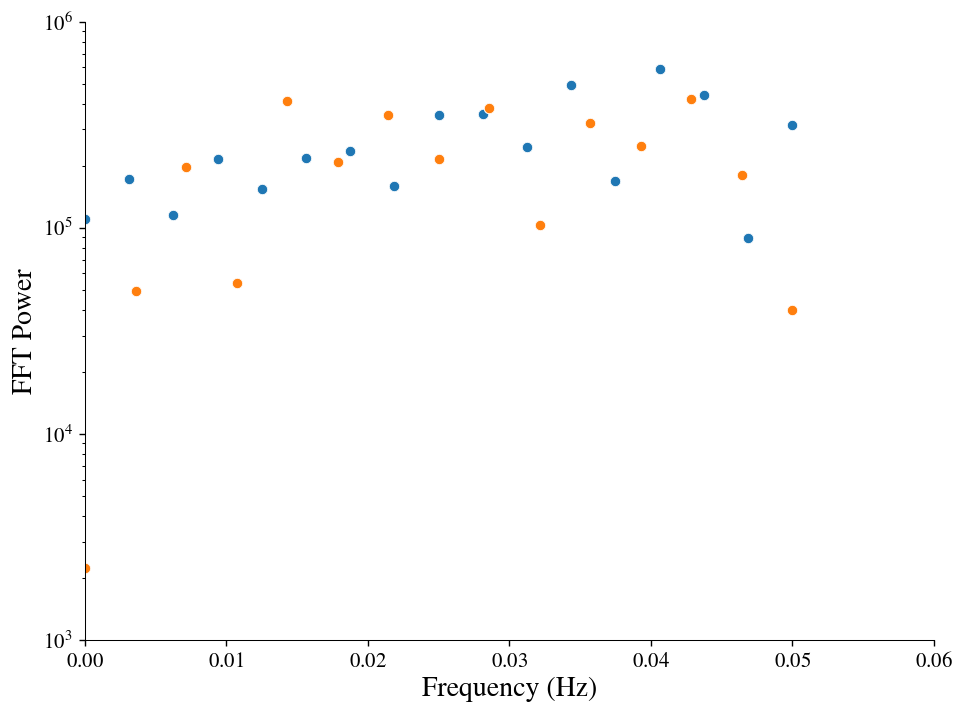

In [13]:
plt.close()

ax = sns.scatterplot(x=freq, y=np.sqrt(np.abs(Y)**2) )
ax = sns.scatterplot(x=freq2, y=np.sqrt(np.abs(Y2)**2) )

ax.set_ylabel("FFT Power")
ax.set_xlabel("Frequency (Hz)")
ax.set(yscale="log")

plt.xlim([0, .06])

plt.tight_layout()

plt.show()
